In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_size = 60000
batch_size = 128
test_size = 10000

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
test_images.shape

(10000, 28, 28)

In [6]:
all_images = np.concatenate((train_images, test_images))

In [7]:
all_images.shape

(70000, 28, 28)

In [8]:
# normalize
all_images = all_images / 255.0

In [9]:
all_images = np.expand_dims(all_images, -1).astype("float32")

In [75]:
all_images.shape

(70000, 28, 28, 1)

In [10]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (28, 28, 1)

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:
vae = VAE(encoder, decoder)

In [16]:
vae.compile(optimizer="adam")

In [17]:
vae.fit(all_images, epochs=500, batch_size=batch_size)

Epoch 1/500
547/547 [==============================] - 35s 61ms/step - loss: 252.3632 - reconstruction_loss: 207.2607 - kl_loss: 3.4982
Epoch 2/500
547/547 [==============================] - 34s 62ms/step - loss: 189.9171 - reconstruction_loss: 184.8132 - kl_loss: 3.3478
Epoch 3/500
547/547 [==============================] - 34s 61ms/step - loss: 181.5460 - reconstruction_loss: 171.8436 - kl_loss: 4.7440
Epoch 4/500
547/547 [==============================] - 33s 61ms/step - loss: 167.0588 - reconstruction_loss: 159.7827 - kl_loss: 6.0424
Epoch 5/500
547/547 [==============================] - 33s 61ms/step - loss: 163.3559 - reconstruction_loss: 156.5741 - kl_loss: 6.2479
Epoch 6/500
547/547 [==============================] - 34s 61ms/step - loss: 161.2735 - reconstruction_loss: 154.5706 - kl_loss: 6.3320
Epoch 7/500
547/547 [==============================] - 34s 62ms/step - loss: 159.7084 - reconstruction_loss: 153.2637 - kl_loss: 6.3492
Epoch 8/500
547/547 [===========================

547/547 [==============================] - 35s 64ms/step - loss: 147.6166 - reconstruction_loss: 141.2287 - kl_loss: 6.5625
Epoch 120/500
547/547 [==============================] - 34s 62ms/step - loss: 147.5276 - reconstruction_loss: 141.1695 - kl_loss: 6.5544
Epoch 121/500
547/547 [==============================] - 34s 62ms/step - loss: 147.2451 - reconstruction_loss: 141.1345 - kl_loss: 6.5467
Epoch 122/500
547/547 [==============================] - 34s 63ms/step - loss: 147.6354 - reconstruction_loss: 141.1175 - kl_loss: 6.5597
Epoch 123/500
547/547 [==============================] - 37s 67ms/step - loss: 147.1632 - reconstruction_loss: 141.1368 - kl_loss: 6.5603
Epoch 124/500
547/547 [==============================] - 36s 65ms/step - loss: 147.7343 - reconstruction_loss: 141.1447 - kl_loss: 6.5676
Epoch 125/500
547/547 [==============================] - 35s 64ms/step - loss: 147.7294 - reconstruction_loss: 141.0587 - kl_loss: 6.5603
Epoch 126/500
547/547 [=========================

KeyboardInterrupt: 

In [18]:
vae.save_weights("vae-mnist-5-weights.h5")

In [19]:
def predict_img():
    random_latent_vectors = np.random.random((1, 28, 28, 1))
    _, _, z = vae.encoder.predict(random_latent_vectors)
    decoded_img = vae.decoder.predict(z)
    fig = plt.figure(figsize=(1, 1))
    plt.imshow(decoded_img[0], cmap="gray")
    plt.show()

1/1 [==============================] - 0s 23ms/step


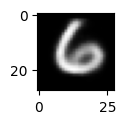

In [21]:
predict_img()

1/1 [==============================] - 0s 21ms/step


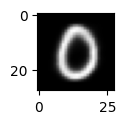

In [26]:
predict_img()

1/1 [==============================] - 0s 20ms/step


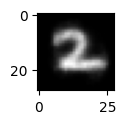

In [74]:
predict_img()